In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

2024-04-22 20:54:09.444469: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 20:54:09.484907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 20:54:10.118832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), use_bias=True, activation="leaky_relu"),
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
      tf.keras.layers.Conv2D(64, (3, 3), use_bias=True, activation="leaky_relu"),
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
      tf.keras.layers.Conv2D(128, (3, 3), use_bias=True, activation="leaky_relu"),
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


In [3]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          800, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((4, 4, 50)),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='leaky_relu', use_bias=True, padding='same'),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='leaky_relu', use_bias=True, padding='same'),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='leaky_relu', use_bias=True, padding='same'),
      tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='leaky_relu', use_bias=True, padding='same')
  ], name="synthesis_transform")


In [4]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for ."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 32, 32, 3))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per  digit.
    rate = tf.reduce_mean(rate)

    # Mean squared difference across pixels.
    distortion = tf.reduce_mean(tf.square(x - x_tilde))


    return dict(rate=rate, distortion=distortion)


In [2]:
training_dataset, validation_dataset = tfds.load(
    "imagenet_resized/64x64",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)


2024-04-22 20:54:12.498138: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1281167 [00:00<?, ? examples/s]

2024-04-23 02:22:40.957486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 02:22:41.236099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 02:22:41.236752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 02:22:41.296009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 02:22:41.296103: I tensorflow/compile

Data type: <dtype: 'uint8'>
Shape: (32, 32, 3)


2024-04-21 21:22:58.442278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-21 21:22:58.442671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


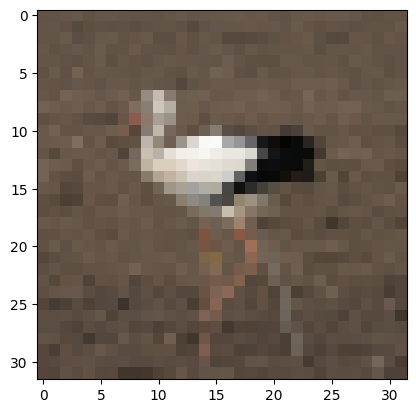

In [6]:
(x, _), = validation_dataset.take(1)

plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


In [7]:
x = tf.cast(x, tf.float32)
x = tf.reshape(x, (-1, 32, 32, 3))
y = make_analysis_transform(10)(x)

print("y:", y)

2024-04-21 21:22:58.827951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2024-04-21 21:22:58.945439: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


y: tf.Tensor(
[[ 17.565386  -11.676329  -10.047781    8.501423   -0.8074007 -22.797611
   -4.348151    8.710267   12.253417  -19.26976  ]], shape=(1, 10), dtype=float32)


2024-04-21 21:22:59.346265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [8]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)

y_tilde: tf.Tensor(
[[ 17.956844   -11.854034   -10.357723     8.812674    -0.57590044
  -23.085016    -4.569817     8.462191    12.195019   -19.401459  ]], shape=(1, 10), dtype=float32)


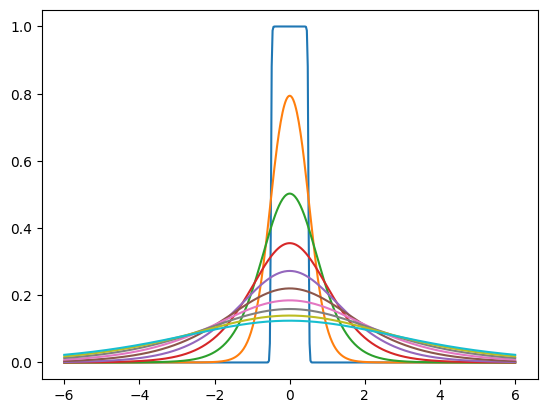

In [9]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


In [10]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)

rate: tf.Tensor([2615.344], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[ 17.31955   -11.904839   -9.7858      8.357452   -0.3855406 -22.886782
   -4.2240806   8.253318   12.344079  -19.106853 ]], shape=(1, 10), dtype=float32)


(1, 32, 32, 3)
distortion: tf.Tensor(87.56199, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (32, 32, 3)


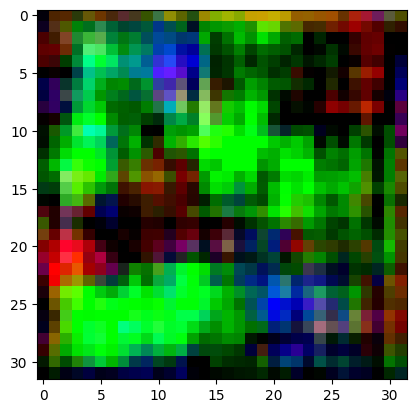

In [11]:
x_tilde = make_synthesis_transform()(y_tilde)
print(x_tilde.shape)
# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


In [12]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = CompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


2024-04-21 21:23:00.101106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-04-21 21:23:00.101455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.25327483, shape=(), dtype=float32)


In [13]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = CompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [14]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)


Epoch 1/15


2024-04-21 21:23:00.995937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [32]
	 [[{{node Placeholder/_4}}]]
2024-04-21 21:23:00.996411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [32]
	 [[{{node Placeholder/_3}}]]
2024-04-21 21:23:04.082827: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f983c0c5d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-21 21:23:04.082907: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX

10010/10010 [==============================] - ETA: 0s - loss: 85.5856 - distortion_loss: 0.0268 - rate_loss: 32.0770 - distortion_pass_through_loss: 0.0268 - rate_pass_through_loss: 32.0759

2024-04-21 21:27:04.454262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-21 21:27:04.454885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


10010/10010 [==============================] - 248s 24ms/step - loss: 85.5856 - distortion_loss: 0.0268 - rate_loss: 32.0770 - distortion_pass_through_loss: 0.0268 - rate_pass_through_loss: 32.0759 - val_loss: 71.2740 - val_distortion_loss: 0.0275 - val_rate_loss: 16.1890 - val_distortion_pass_through_loss: 0.0275 - val_rate_pass_through_loss: 16.1888
Epoch 2/15
10010/10010 [==============================] - 251s 25ms/step - loss: 71.1952 - distortion_loss: 0.0259 - rate_loss: 19.3822 - distortion_pass_through_loss: 0.0259 - rate_pass_through_loss: 19.3823 - val_loss: 69.2967 - val_distortion_loss: 0.0262 - val_rate_loss: 16.9777 - val_distortion_pass_through_loss: 0.0262 - val_rate_pass_through_loss: 16.9773
Epoch 3/15
10010/10010 [==============================] - 265s 26ms/step - loss: 70.7604 - distortion_loss: 0.0257 - rate_loss: 19.2841 - distortion_pass_through_loss: 0.0257 - rate_pass_through_loss: 19.2843 - val_loss: 68.9872 - val_distortion_loss: 0.0259 - val_rate_loss: 17.22

In [15]:
class Compressor(tf.keras.Model):
  """Compresses  images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

In [16]:
class Decompressor(tf.keras.Model):
  """Decompresses  images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


In [17]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)


In [18]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)

2024-04-21 22:24:49.087241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-21 22:24:49.087768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


In [19]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0xc896
Number of bits actually needed to represent it: 9.75


In [20]:
reconstructions = decompressor(strings)

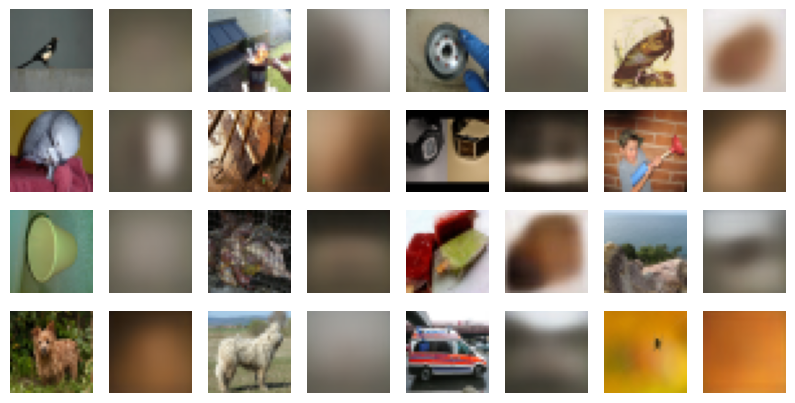

In [21]:
# Display the original and reconstructed images.
plt.figure(figsize=(10, 5))
for i, (original, reconstruction) in enumerate(zip(originals, reconstructions)):
  plt.subplot(4, 8, 2 * i + 1)
  plt.imshow(tf.squeeze(original))
  plt.axis("off")
  plt.subplot(4, 8, 2 * i + 2)
  plt.imshow(tf.squeeze(reconstruction))
  plt.axis("off")

In [22]:
# trainer.save_weights("models/unbounded_compression_conv2d.h5")

In [26]:
trainer.save_weights("models/unbounded_compression_conv2d.h5")